In [1]:
#単純パーセプトロンの実装(シンプルな1層のNNであり、分類タスクを行うことができる)
import numpy as np
import pandas as pd

class Perceptron(object):
    """
    params:
    ---------------
    eta: float
    学習率であり、0から1の値をとる
    
    n_iter: int
    EPOCH数
    
    random_state: int
    乱数シード
    
    w_: 1次元配列
    学習後の重み
    
    erros: list
    各エポックでの誤答率
     """
    
    def __init__(self,eta=0.01,n_iter=50,random_state=1):
        self.eta = eta
        self.n_iter = n_iter
        self.random_state = random_state
     
    
    
    def fit(self, X, y):
        rgen = np.random.RandomState(self.random_state)
        self.w_ = rgen.normal(loc=0.0, scale=0.01, size=1 + X.shape[1])
        self.errors_ = []

        for _ in range(self.n_iter):
            errors = 0
            for xi, target in zip(X, y):
                update = self.eta * (target - self.predict(xi))
                self.w_[1:] += update * xi
                self.w_[0] += update
                errors += int(update != 0.0)
            self.errors_.append(errors)
        return self
    
    def net_input(self,X):
        """総入力を計算"""
        return np.dot(X, self.w_[1:]) + self.w_[0]
    
    def predict(self,X):
        """predict　1ステップ後のクラスラベルを返す"""
        #self.net_input(X) >= 0.0 を条件式として、Trueなら1を、Falseなら-1をarrayとして返す
        #単に線形結合した結果のスコアが0より大きいなら、予測ラベルとして1を、そうでないなら予測ラベル0を出力するということ
        return np.where(self.net_input(X) >= 0.0, 1, -1)
    

In [2]:
#Irisデータセットを使い、単純パーセプトロンが分類を行えることを確認する
import os
import pandas as pd


df = pd.read_csv('C:/Users/unlea/Desktop/Python 3/ML_Master/python-machine-learning-book-3rd-edition/ch02/iris.data', header=None)
df.head()

,0,1,2,3,4
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


Text(0, 0.5, 'petal length(cm)')

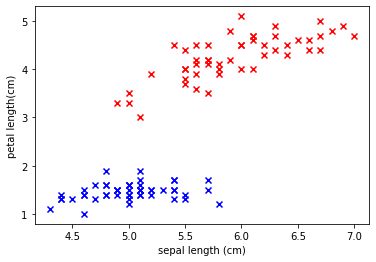

In [3]:
import matplotlib.pyplot as plt

#Xを定義
#1-100行目の目的変数抽出
X = df.iloc[0:100,[0,2]].values

#yを定義
#1-100行目の目的変数抽出
y = df.iloc[0:100,4].values
y = np.where(y=='Iris-setosa',-1,1)

#Setosaのplot
plt.scatter(X[:50,0],X[:50,1],color='blue',marker='x')

#cersicolorのplot
plt.scatter(X[50:100,0],X[50:100,1],color='red',marker='x')

#writing label
plt.xlabel('sepal length (cm)')
plt.ylabel('petal length(cm)')

#分類結果をみると、二次元上では、線形で十分分離が可能

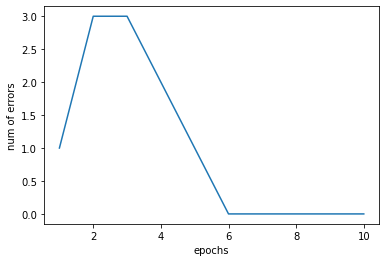

In [4]:
#作成したパーセプトロンを訓練する。
ppn = Perceptron(eta=0.1,n_iter=10)

ppn.fit(X,y)

#Epochと誤分類の関係性を示すグラフをplot
plt.plot(range(1, len(ppn.errors_) + 1), ppn.errors_)

plt.xlabel('epochs')
plt.ylabel('num of errors')
plt.show()

C:\Users\unlea\AppData\Local\Temp\ipykernel_20156\1120327749.py:34: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(x=X[y == cls, 0],


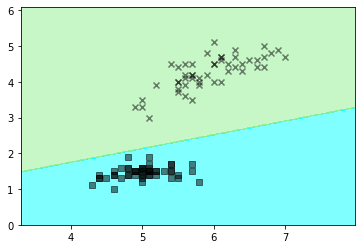

In [5]:
#決定境界を可視化する
from matplotlib.colors import ListedColormap

def plot_decision_boundary(X,y,clf,resolution=0.02):
    
    #マーカーとカラーマップ準備
    markers = ('s','x','o','^','v')
    colors = ('cyan','lightgreen','red','yellow','black')
    cmap = ListedColormap(colors[:len(np.unique(y))])
    
    #決定領域をプロットするために、X1とX2の最大値と最小値をそれぞれだしておく
    x1_min, x1_max = X[:,0].min()-1, X[:,0].max()+1
    x2_min, x2_max = X[:,1].min()-1, X[:,1].max()+1
    
    #grid point(x,yの座標軸)
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    
    #各特徴量を1次元配列にしてから予測する
    #np.array(xx1,xx2)だと、ヨコ方向にX1,X2がだーっと並んでいるので
    #転置してあげて、特徴量行列にした上でpredictに投入
    Z = clf.predict(np.array([xx1.ravel(),xx2.ravel()]).T)
    
    #predict結果は、特徴量X1と同じ形状にしておく
    Z = Z.reshape(xx1.shape)
    
    #等高線
    plt.contourf(xx1,xx2,Z,alpha=0.5,cmap=cmap)
    
    plt.xlim(xx1.min(),xx1.max())
    plt.ylim(xx2.min(),xx2.max())
    
    for i,cls in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cls, 0],
                    y=X[y == cls, 1],
                    alpha=0.5,
                    c='black',
                    marker=markers[i],
                    edgecolor='black')
    

plot_decision_boundary(X,y,ppn,resolution=0.02)

In [6]:
#ADALINE
#活性化関数としては恒等関数を用い、損失関数に-Σ(y(i) - WtX(i))*Xkを使うのが特徴
class AdaLineGD(object):
    
    def __init__(self,eta=0.01,n_iter=100,random_state=1):
        self.eta = eta
        self.n_iter = n_iter
        self.random_state = random_state
        
        
    def fit(self, X, y):
        #単純パーセプトロンでやったのと基本的には同じだが
        #重みの更新の部分は異なるので、そこはコメント入れている
        
        rgen = np.random.RandomState(self.random_state)
        
        self.w_ = rgen.normal(loc=0.0, scale=0.01, size = X.shape[1] + 1)
        
        self.cost_ = []
        
        for i in range(self.n_iter):
            net_input = self.net_input(X)
            """
            activationメソッドは単なる恒等関数でしかないため、
            ここでは、self.activation()の機能は実装せず、単にnet_inputが
            outputになる。シグモイドの場合は,activationにシグモイド関数を使うことになる
            """
            output = self.activation(net_input)
            
            #誤差の計算(yi - φ(Zi))の部分
            #SSEの形では計算しない。なぜなら単純なyi-ziの計算部分が、損失関数の微分結果に含まれるため。
            error = (y - output)
            
            #重み[w1.....wm]の更新
            #重みのウェイト部分は,以下の式によって更新される
            """
            δJ/δwj = -Σ(yi-zi)*xk(i)
            Wnew = Wold - γ(δJ/δwj) より
            Wnew = Wold + γ* np.dot((yi-zi),xk(i))
            
            """
            self.w_[1:] += self.eta * (np.dot(X.T,error))
            
            #バイアスw0の更新
            """
            δJ/δwj = Σ(yi-zi)*-1より
            Wnew = Wold - γ(δJ/δwj) より
            Wnew = Wold + γ* (yi-zi).sum()
            
            """
            self.w_[0] += self.eta * error.sum()
            
            #コスト関数の計算(SSE): 1/2Σ(yi-zi)^2
            cost = (error**2).sum() / 2.0
            
            #更新後の重みでの、誤差を格納
            self.cost_.append(cost)
            
        return self

    def net_input(self,X):
        #線形重み和を出力
        return np.dot(X,self.w_[1:]) + self.w_[0]

    def activation(self,X):
        #activation関数。ADALINEは活性化関数は恒等関数なのでただ線形重み和を返すだけ
        return X

    def predict(self,X):
        #未知のXに対するyの予測値を返す。
        return np.where(self.activation(self.net_input(X)) >= 0.0, 1.0, -1.0)
    

C:\Users\unlea\AppData\Local\Temp\ipykernel_20156\2813935161.py:54: RuntimeWarning: overflow encountered in square
  cost = (error**2).sum() / 2.0
C:\Users\unlea\anaconda3\lib\site-packages\numpy\core\_methods.py:48: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)


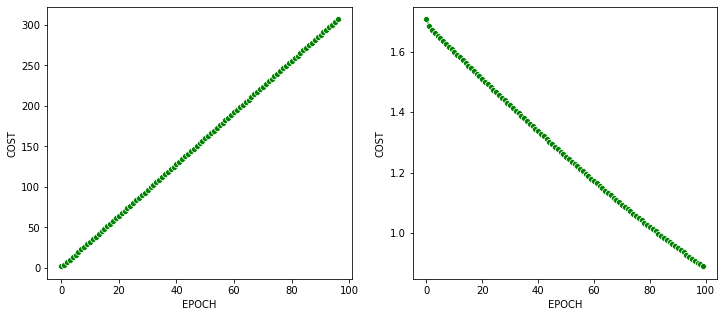

In [7]:
import seaborn as sns
#作成したADALINE学習器が、コストが0になるように収束するのかを確認する
fig,axes = plt.subplots(1,2,figsize=(12,5))

eta = [0.01,0.0001]

#Epochとコストの関係性を表すグラフを描画する
for i,ax in enumerate(axes.flatten()):
    #勾配降下法による、ADALINEの学習@学習率0.01
    ADA = AdaLineGD(eta=eta[i],n_iter=100,random_state=1).fit(X,y)
    sns.lineplot(x=range(len(ADA.cost_)), y=np.log10(ADA.cost_),ax=ax,marker='o',color='g')
    ax.set_xlabel('EPOCH')
    ax.set_ylabel('COST')
#学習率が大きすぎると、Wの大域的な最適解に収束しないため、いつまでたっても、望ましい方向に
#重みの勾配を下ることは出来ず、結局EPOCHが増えるにつれ損失も大きくなってしまう。

#適切な学習率(0.0001)では、ただしくコストが0に向かって収束している。
#ただし、学習率が小さい場合、それに応じてEPOCHの回数を大きくしなければならないこともわかる

In [8]:
#より早い収束のためには、データを標準化することが必要となる
#StandardScaleを行う
X_std = X.copy()

#各列を、標準化する
X_std[:,0] = (X[:,0] - np.mean(X[:,0]))/X[:,0].std()
X_std[:,1] = (X[:,1] - np.mean(X[:,1]))/X[:,1].std()

C:\Users\unlea\AppData\Local\Temp\ipykernel_20156\2813935161.py:54: RuntimeWarning: overflow encountered in square
  cost = (error**2).sum() / 2.0
C:\Users\unlea\anaconda3\lib\site-packages\numpy\core\_methods.py:48: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
C:\Users\unlea\AppData\Local\Temp\ipykernel_20156\1120327749.py:34: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(x=X[y == cls, 0],
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


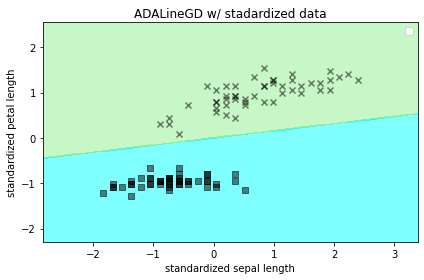

In [9]:
#標準化したデータで改めて、ADALINEGDを試してみると、、
ADA2 = AdaLineGD(eta=0.01,n_iter=100,random_state=1).fit(X,y)
ADA2.fit(X_std,y)

#決定境界のプロット
plot_decision_boundary(X_std,y,ADA2)
plt.title('ADALineGD w/ stadardized data')
plt.xlabel('standardized sepal length')
plt.ylabel('standardized petal length')
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()


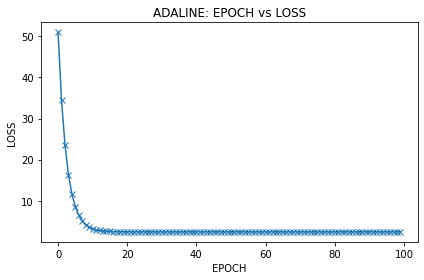

In [10]:
#Epochとコストの関係性をplot
plt.plot(range(len(ADA2.cost_)),ADA2.cost_,marker='x')
plt.title('ADALINE: EPOCH vs LOSS')
plt.xlabel('EPOCH')
plt.ylabel('LOSS')
plt.tight_layout()
plt.show()

In [11]:
#Adalineを、学習ごとに全データの勾配を求める勾配降下法ではなく、細かいバッチ単位で学習を行う
#SGDの手法で重みを更新する

import numpy as np

class AdalineSGD(object):
    """
    params:
    ------------
    eta: float
    学習率
    
    n_iter:int
    EPOCH数
    
    shuffle: bool(default=True)
    各バッチで学習データをランダムに取り出すかどうか
    （取り出さなければいけないのでdefault=True）
    
    random_state: int
    乱数シード
    
    """
    def __init__(self,eta=0.01,n_iter=100,shuffle=True,random_state=1):
        self.eta = eta
        self.n_iter = n_iter
        self.shuffle = shuffle
        self.random_state = random_state
        #重みの初期化フラグはFalseに設定する
        self.w_initialized = False
        
    def fit(self,X,y):
        """fit method
        params:
        -----------------------
        X: traindata
        shape = {n_examples, n_features}
        y: targetdata
        shape = {n_examples,1}
        -----------------------
        return:
        self: object
        -----------------------
        """
        #重みベクトル生成
        self._initialize_weights(X.shape[1])#_initialize_weights関数で生成する
        
        #コストを格納するリスト
        self.cost_ = []
        
        #訓練回数分データを反復する
        for i in range(self.n_iter):
            #self.shuffle=Trueなら訓練データをシャッフル
            if self.shuffle:
                X,y = self._shuffle(X,y)
                
            #各訓練データのコストを格納するリストをつくる
            cost = []
            
            #各訓練データに対する計算
            for xi,target in zip(X,y):
                #特徴量xiと目的変数を使い、重み更新&コストを計算し、costに格納する
                cost.append(self._update_weights(xi,target))
                
            #訓練データの平均コストを計算する
            avg_cost = np.sum(cost)/len(y)
            
            #self.cost_に平均コストを格納
            self.cost_.append(avg_cost)
            
        return self#学習した自クラスを返す
    
    def partial_fit(self,X,y):
        """オンライン学習を行う場合、重みを再度初期化することなく、訓練データに適合させる"""
        #重みが初期化されていない場合、初期化する
        if not self.w_initialized:
            self._initialize_weights(X.shape[1])
            
        if y.ravel().shape[1] >= 2:
            for xi,target in zip(X,y):
                self._update_weights(xi,target)
                
        else:
            self._update_weights(xi,target)
            
    def _shuffle(self,X,y):
        """訓練データをシャッフル"""
        #np.permutation(int or array)
        #xが整数(int)の場合は、np.arange(x)の配列をランダムに並べ替える。
        #xが配列の場合は、その配列をコピーして要素をランダムに並べ替える。
        #range(len(y))をランダムに並び替えることで、ランダムに並び替えられたindexを取得している
        r = self.rgen.permutation(len(y))
        
        return X[r],y[r]
        
    def _initialize_weights(self,m):
        """重みを小さい乱数で初期化"""
        self.rgen = np.random.RandomState(self.random_state)
        #形状(1 , m+1)の配列であって、avg=0.0,sd=0.01に従うガウス分布から乱数を生成する
        #形状をm+1としているのは、バイアスのためである
        self.w_ = self.rgen.normal(loc=0.0,scale=0.01,size=1+m)
        #この関数を実行したら、self.w_initializedにTrueフラグを渡す。上で識別に使う
        self.w_initialized = True
        
    def _update_weights(self,xi,target):
        """重みの更新"""
        #活性化関数の出力を計算
        output = self.activation(self.net_input(xi))
        #誤差の計算
        error = (target - output)
        #バイアス以外の重みの更新
        self.w_[1:] += self.eta * np.dot(xi.T,error)
        #バイアスの更新
        self.w_[0] += self.eta * error
        #コスト計算(1/2 * Error**2)
        cost = 0.5 * error**2
        #コストを返す
        return cost
    
    def net_input(self,X):
        """単なるAffine"""
        return np.dot(X, self.w_[1:]) + self.w_[0]
    
    def activation(self,X):
        """活性化関数だが、恒等関数なのでなにもせずにXをかえすだけ"""
        return X
    
    def predict(self,X):
        """prediction"""
        return np.where(self.activation(self.net_input(X)) >= 0.0, 1.0, -1.0)

C:\Users\unlea\AppData\Local\Temp\ipykernel_20156\1120327749.py:34: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(x=X[y == cls, 0],
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


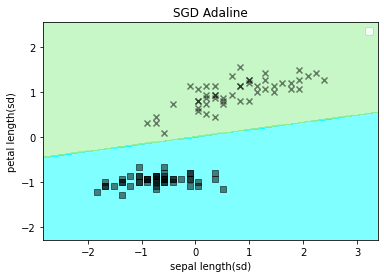

In [12]:
ada3 = AdalineSGD(n_iter=50,eta=0.01,random_state=0)
ada3.fit(X_std,y)
#決定境界の描画
plot_decision_boundary(X_std,y,ada3,resolution=0.02)
plt.title('SGD Adaline')
plt.xlabel('sepal length(sd)')
plt.ylabel('petal length(sd)')
plt.legend(loc='upper right')
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


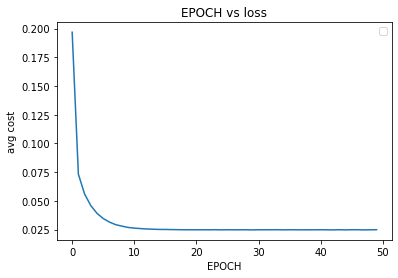

In [13]:
#Epochとコストの減少度合いを描画する
sns.lineplot(x=range(len(ada3.cost_)),y=ada3.cost_)
plt.title('EPOCH vs loss')
plt.xlabel('EPOCH')
plt.ylabel('avg cost')
plt.legend()

データ全体をEPOCHごとにみて重みを更新するのではなく<br>
１つのデータから成るバッチをシャッフルして、都度都度重みを更新(SGD)で学習した場合、早く収束する<br>
→学習データ全体をループするたびに重みを更新するのではなく、バッチの学習を終えるたびに重みを更新するから、重みの更新頻度が高いため